### Importing relevant Libraries :

In [ ]:
# This notebook is the exact same as its corresponding file but instead of having a set random state, it has a for loop which loops on a random number generator and 
# generates a mean OR out of a hundred runs.

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
import seaborn as sns
from sklearn.model_selection import train_test_split

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set()

In [ ]:

import pandas as pd

df1 = pd.read_csv('./mami_data_file.csv', sep = ',', parse_dates=True)
dfgenos = pd.read_csv('./Male_genos.csv', sep = ',', parse_dates=True)

dfgenos.dropna(how = 'all')

df = pd.merge(df1,dfgenos,on= 'Dnumber')


In [ ]:

cleanup = {'CaConRel':{1: 0, 2: 1, 3 : ' '},'q_15':{'15b':0, '15a':1}}

df.replace(cleanup, inplace=True)

# The empty spaces are being replaced to NaNs i.e. missing values
df.replace(' ', np.NaN, inplace=True)


### Determining the variables of interest:

In [ ]:
# Working on a subset of the dataset. This is needed before removing the missing 
# values so that most of the rows are still conserved
cols_tobe_selected = pd.concat([df.iloc[:,162:len(df.columns)],df[['TRIG_FOL_ALL','Age','Gender', 'CaConRel','rs2305948', 'rs1801177', 'rs45539933','rs11669576', 'rs9527025', 'rs533617', 'rs2228315','rs11466653']]],axis= 1)

working_df = cols_tobe_selected.dropna()
working_df.reset_index(drop=True, inplace=True)


In [ ]:
# specifying only males
working_df_males = working_df[working_df['Gender'] == '2']



In [ ]:
# Setting specific columns as numeric instead of object

obj_to_numeric_cols = ['Age','TRIG_FOL_ALL','CaConRel' ]

working_df_males[obj_to_numeric_cols]= working_df_males[obj_to_numeric_cols].apply(pd.to_numeric)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
# Setting specific columns as string instead of float

num_to_obj_cols = working_df_males.loc[:, ~working_df_males.columns.isin(obj_to_numeric_cols)].columns

working_df_males[num_to_obj_cols]= working_df_males[num_to_obj_cols].astype(str)


### Creating Dummy Variables :

In [ ]:
# Dummies created automatically for the object type variables. Original variables
# are dropped to folow the N-1 rule 

working_df_males = pd.get_dummies(working_df_males, drop_first=True)
working_df_males.columns


Index(['TRIG_FOL_ALL', 'Age', 'CaConRel', 'rs3193672_2', 'rs3193672_3',
       'rs318801_2', 'rs318801_3', 'rs321775_2', 'rs321775_3', 'rs7022_2',
       'rs7022_3', 'rs675_2.0', 'rs675_3.0', 'rs174465_2', 'rs174465_3',
       'rs4520_2', 'rs4520_3', 'rs4225_2', 'rs4225_3', 'rs907_2', 'rs907_3',
       'rs2017964_2', 'rs2017964_3', 'rs28668976_2', 'rs28668976_3',
       'rs2305948_2', 'rs2305948_3', 'rs1801177_2', 'rs1801177_3',
       'rs45539933_2', 'rs45539933_3', 'rs11669576_2', 'rs9527025_2',
       'rs9527025_3', 'rs533617_2', 'rs533617_3', 'rs2228315_2', 'rs2228315_3',
       'rs11466653_2', 'rs11466653_3'],
      dtype='object')

### Linear Regression Model :

In [ ]:
from sklearn.preprocessing import StandardScaler
import random

odds_ratio_results = []
conf_int_results = []

for _ in range(100):

  random_state = random.randint(0, 1000000)

  inputs_cases = working_df_males[working_df_males['CaConRel'] == 1]
  inputs_ctrls = working_df_males[working_df_males['CaConRel'] == 0]


  # Declaring the Inputs (Predictors) and Target

  targets_cases = inputs_cases['TRIG_FOL_ALL']
  targets_ctrls = inputs_ctrls['TRIG_FOL_ALL']

  inputs_cases = inputs_cases.drop(['TRIG_FOL_ALL','CaConRel'],axis =1)
  inputs_ctrls = inputs_ctrls.drop(['TRIG_FOL_ALL','CaConRel'],axis =1)

  cols_for_scaling_cases = inputs_cases.loc[:, ~inputs_cases.columns.isin(['Age'])].columns
  cols_for_scaling_ctrls = inputs_ctrls.loc[:, ~inputs_ctrls.columns.isin(['Age'])].columns

  ##

  inputs_ctrls_train, inputs_ctrls_test, targets_ctrls_train, targets_ctrls_test = train_test_split(inputs_ctrls, targets_ctrls, random_state=random_state, train_size = .8)
  
  test_set = pd.concat([inputs_ctrls_train, inputs_ctrls_test, inputs_cases])
  test_target_set = pd.concat([targets_ctrls_train, targets_ctrls_test, targets_cases])
  ## 

  scaler = StandardScaler()

  inputs_ctrls_test_scaled = scaler.fit_transform(inputs_ctrls_test[['Age']])
  inputs_ctrls_test_scaled_df = pd.DataFrame(data=inputs_ctrls_test_scaled, columns= ['Age'], index=inputs_ctrls_test.index) 
  inputs_ctrls_test = pd.concat([inputs_ctrls_test_scaled_df, inputs_ctrls_test[cols_for_scaling_ctrls]], axis=1)

  inputs_ctrls_scaled = scaler.fit_transform(inputs_ctrls_train[['Age']])
  inputs_ctrls_scaled_df = pd.DataFrame(data=inputs_ctrls_scaled, columns= ['Age'], index=inputs_ctrls_train.index) 
  inputs_ctrls_train = pd.concat([inputs_ctrls_scaled_df, inputs_ctrls_train[cols_for_scaling_cases]], axis=1)

  inputs_cases_scaled = scaler.fit_transform(test_set[['Age']])
  inputs_cases_scaled_df = pd.DataFrame(data=inputs_cases_scaled, columns= ['Age'], index=test_set.index) 
  inputs_cases = pd.concat([inputs_cases_scaled_df, test_set[cols_for_scaling_ctrls]], axis=1)

  ##

  #x_train and y_train = 80% of controls to train the model

  x_test = inputs_cases 
  x_train = inputs_ctrls_train 

  y_test = test_target_set
  y_train = targets_ctrls_train

  # Fitting the Regression Model using the training dataset

  reg = LinearRegression().fit(x_train, y_train)

  # Predict response of a combination of x_train and x_test

  x_conc = x_test
  y_conc = test_target_set

  y_hat_conc = reg.predict(x_conc)

  ## LOGISTIC REGRESSION

  # y_hat_conc is split according to CaConRel value 0 (controls)

  y_hat_conc_ctrl = y_hat_conc[working_df_males['CaConRel'][x_conc.index]==0]
  y_hat_conc_cases = y_hat_conc[working_df_males['CaConRel'][x_conc.index]==1]

  # separated y_hat_conc_ctrl into quartiles. The intervals will be used to split y_hat_conc
  pd.qcut(y_hat_conc_ctrl, q=4,labels=['1', 
                                  '2', 
                                  '3',  
                                  '4']) 

  testcut_series, testcut_intervals = pd.qcut(y_hat_conc_ctrl, q=4,labels=['1','2', '3','4'],retbins=True) 

  GRS_TG = []

  for i in y_hat_conc: 
    if i <= testcut_intervals[1]:
      GRS_TG.append(1)
    elif i <= testcut_intervals[2]:
      GRS_TG.append(2)
    elif i <= testcut_intervals[3]:
      GRS_TG.append(3)
    elif i > testcut_intervals[3]:
      GRS_TG.append(4)
    else:
      print('NaN')


  GRS_TG_index = pd.DataFrame(index=x_conc.index)
  GRS_TG_index['GRS'] = GRS_TG

  ##

  # getting the individuals(indices) from the Caconrel variable which correspond to the testing set indices. Thus, the cases.
  target = working_df_males['CaConRel']

  logreg_ytrain = target.loc[x_conc.index]

  # The predicted variable from the linear regression will be the used as the input in the logistic regression

  logreg_xtrain = y_hat_conc

  ##
  # Getting dummy variables for the categorical variable GRS_TG

  GRS_TG_dum = pd.get_dummies(GRS_TG, drop_first=True, prefix="GRS")

  x2 = GRS_TG_dum
  y2 = logreg_ytrain.reset_index()

  ##

  x2_index = x2.set_index(x_conc.index)

  # Fitting Logistic Regression Model

  x2 = sm.add_constant(x2)
  reg_log2 = sm.Logit(y2['CaConRel'],x2.reset_index(drop= True))
  results_log2 = reg_log2.fit()

  ##

  df2 = pd.read_html(results_log2.summary().tables[1].as_html(),header=0,index_col=0)[0]
  odds_ratio_results.append(pd.DataFrame(np.exp(df2['coef'].values)))

  ##

  conf_int_res2 = results_log2.conf_int(alpha=0.1)

  conf_int_results.append(pd.DataFrame(np.exp(conf_int_res2.values)))



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.673422
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.673842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668532
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.671265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673007
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.672082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673743
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.672254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674325
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.674372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673201
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.674199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673165
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.671737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673465
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.673082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673734
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.666721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671518
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.673309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672010
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.670019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673659
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.673612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673642
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.672305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672004
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.672823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673548
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.673789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671529
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.674256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673527
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.668509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672708
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.671610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673442
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.669128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673893
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.672438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674186
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.671947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671822
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.674212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672395
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.673067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671579
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673625

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)



         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673555
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.673344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672735
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.674230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668494
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.671423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673662
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669841
         Iterations 5


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.672868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669460
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.674151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674358
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.670517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660290
         Iterations 5


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.670752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667525
         Iterations 5


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.672890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671974
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.670211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672457
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.673527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673793
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.672769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670122
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.672244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672440
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.664493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673495
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.671529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672003
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.669714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674199
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.674258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673844
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.669442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673842
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.673844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667702
         Iterations 5


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.674245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671928
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.672591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673221
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.673604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673792
         Iterations 4


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
first_col_arr = []
second_col_arr = []

for result_df in conf_int_results:
  first_col = result_df.iloc[:, 0]
  second_col = result_df.iloc[:, 1]

  first_col_arr.append(first_col)
  second_col_arr.append(second_col)

In [ ]:
# Mean ORs
pd.concat([pd.concat(first_col_arr, axis=1).T.mean(), pd.concat(second_col_arr, axis=1).T.mean()], axis=1)

,0,1
0,0.457345,0.847589
1,0.776206,1.830168
2,0.668421,1.602421
3,0.781294,1.838901


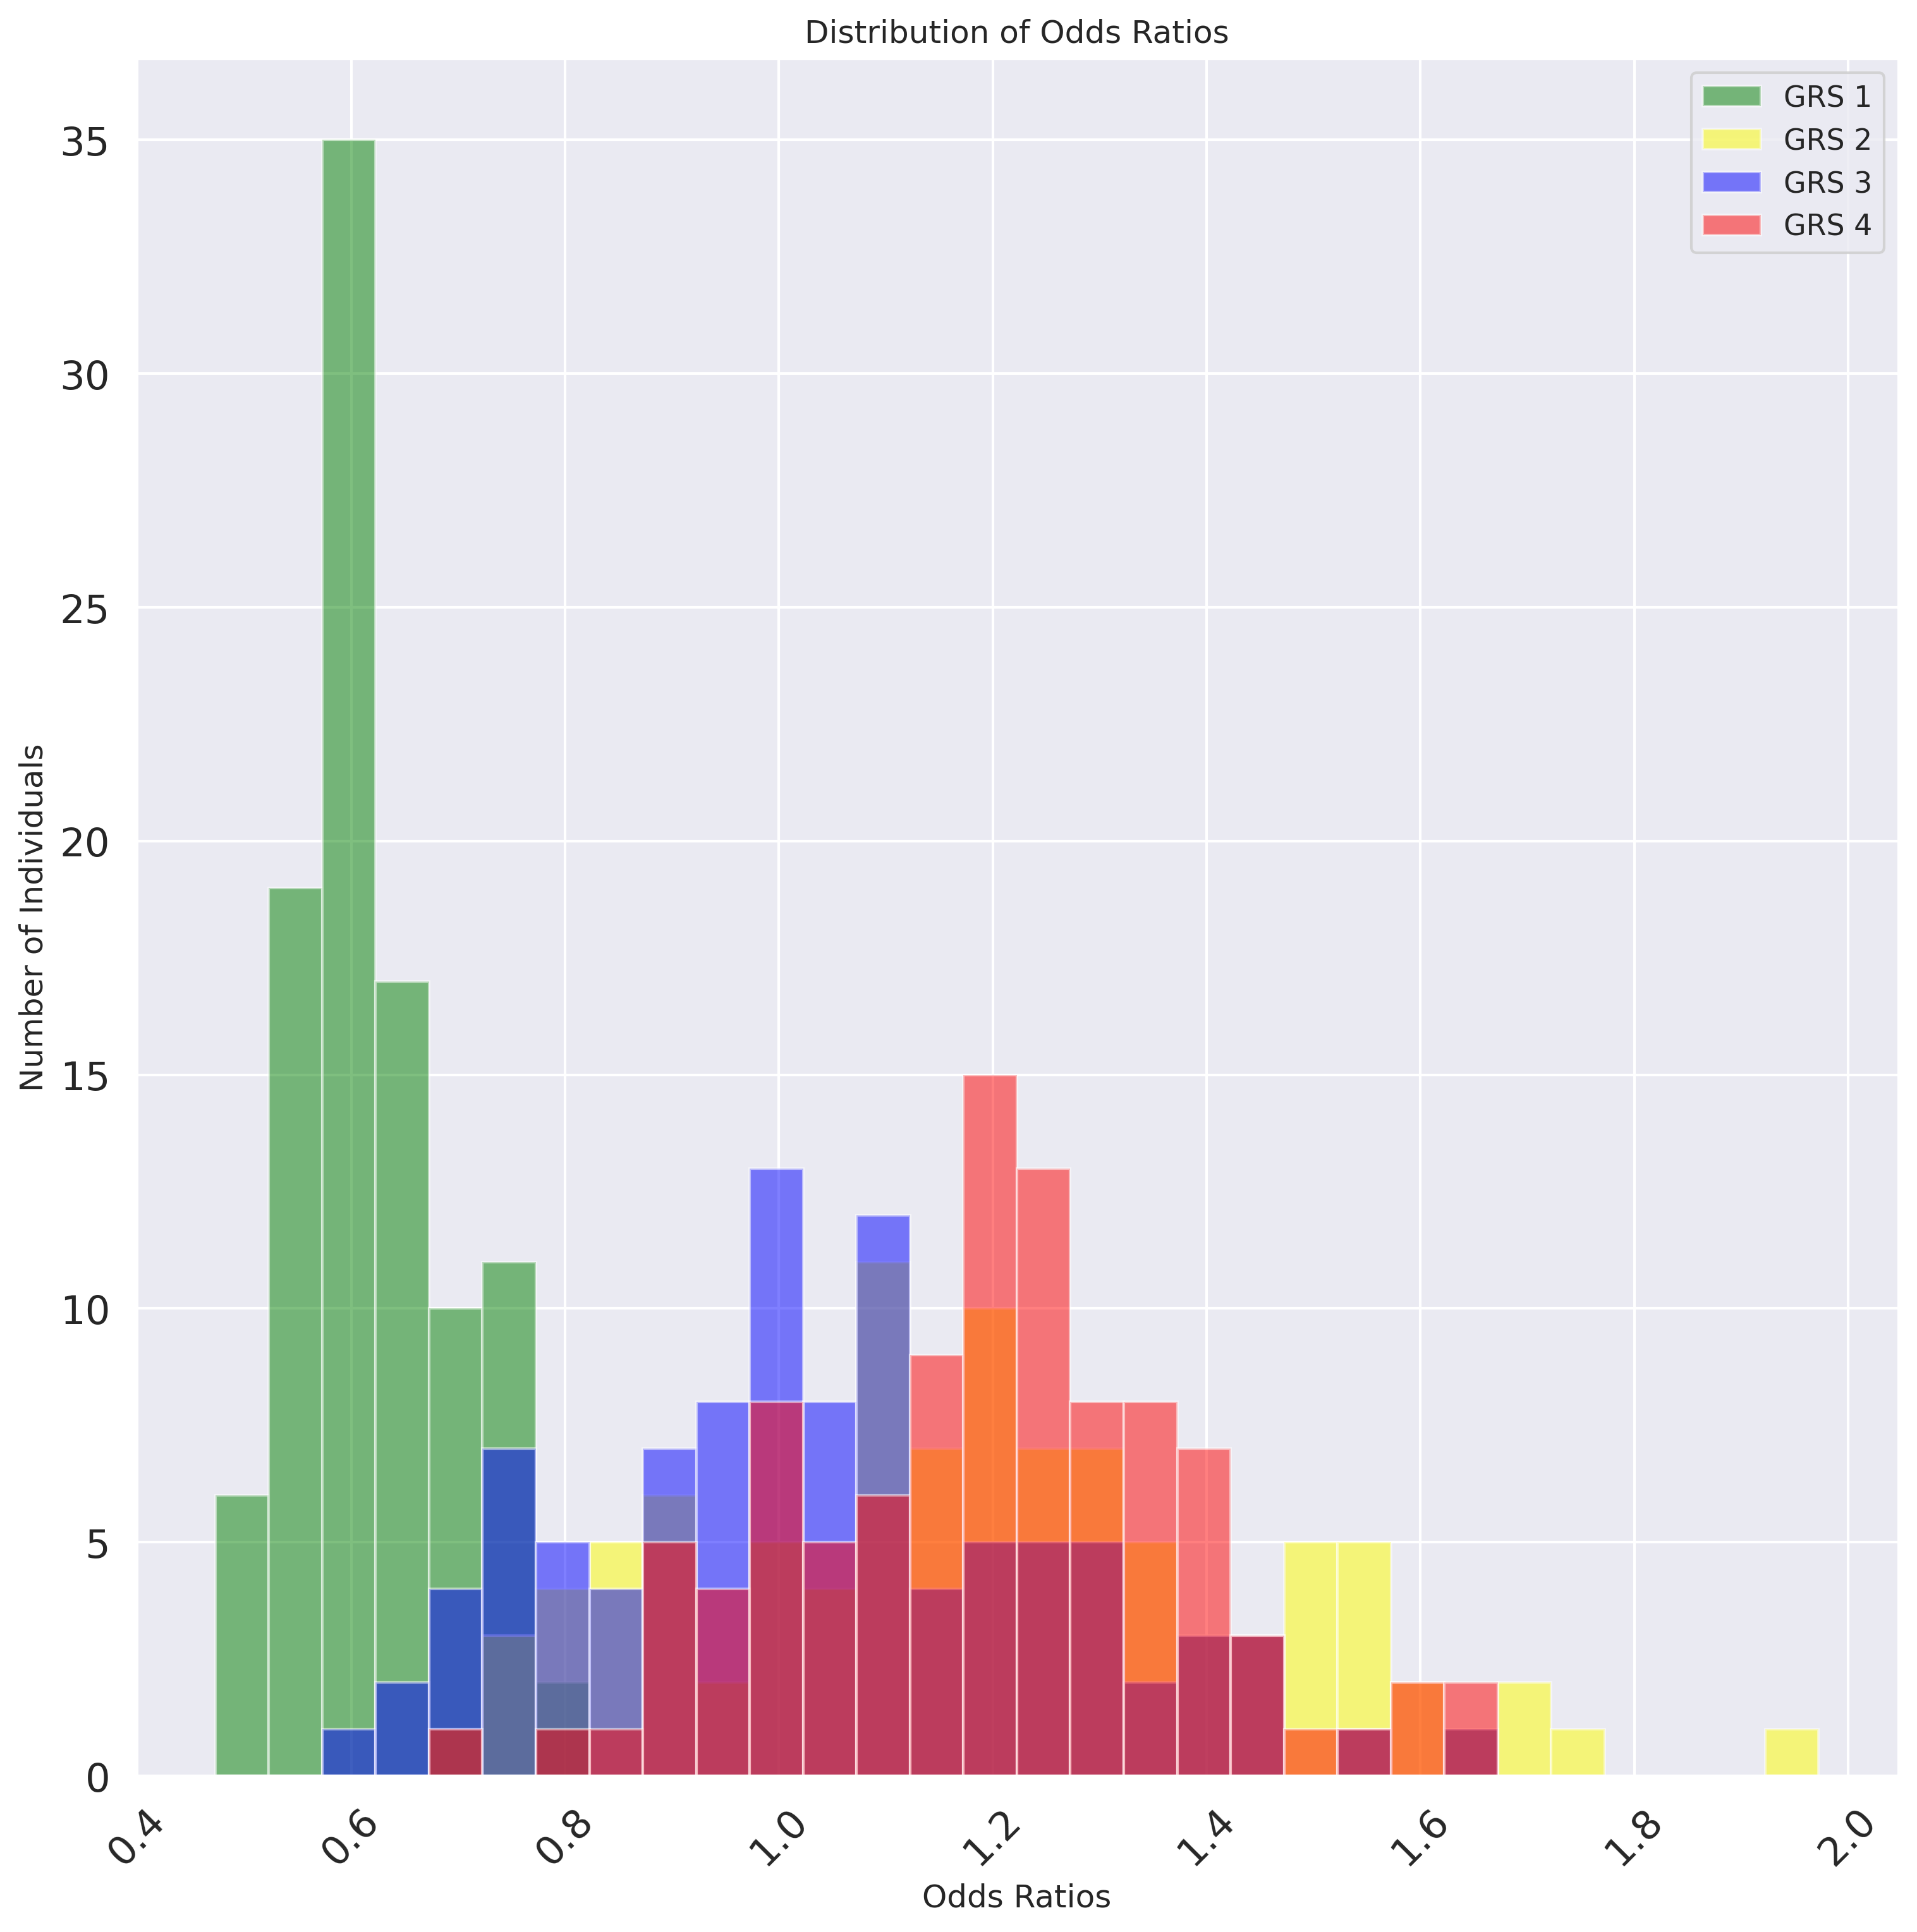

In [ ]:
# Distribution of ORs

ORS_multi_result = pd.concat(odds_ratio_results, axis=1).T

ORS_multi_result = ORS_multi_result.rename(columns={0: 'GRS 1', 1: 'GRS 2', 2: 'GRS 3', 3: 'GRS 4'}).reset_index(drop = True)

ORS_multi_result.plot(kind='hist',
        alpha=0.5,
        bins=30,
        title='Distribution of Odds Ratios',
        rot=45,
        grid=True,
        figsize=(12,12),
        fontsize=15,      
        color=['green', 'yellow', 'blue', 'red'])
plt.xlabel('Odds Ratios')
plt.ylabel('Number of Individuals');



In [ ]:
dist_df = ORS_multi_result.reset_index(drop = True)
dist_df['GRS 1'] = 1

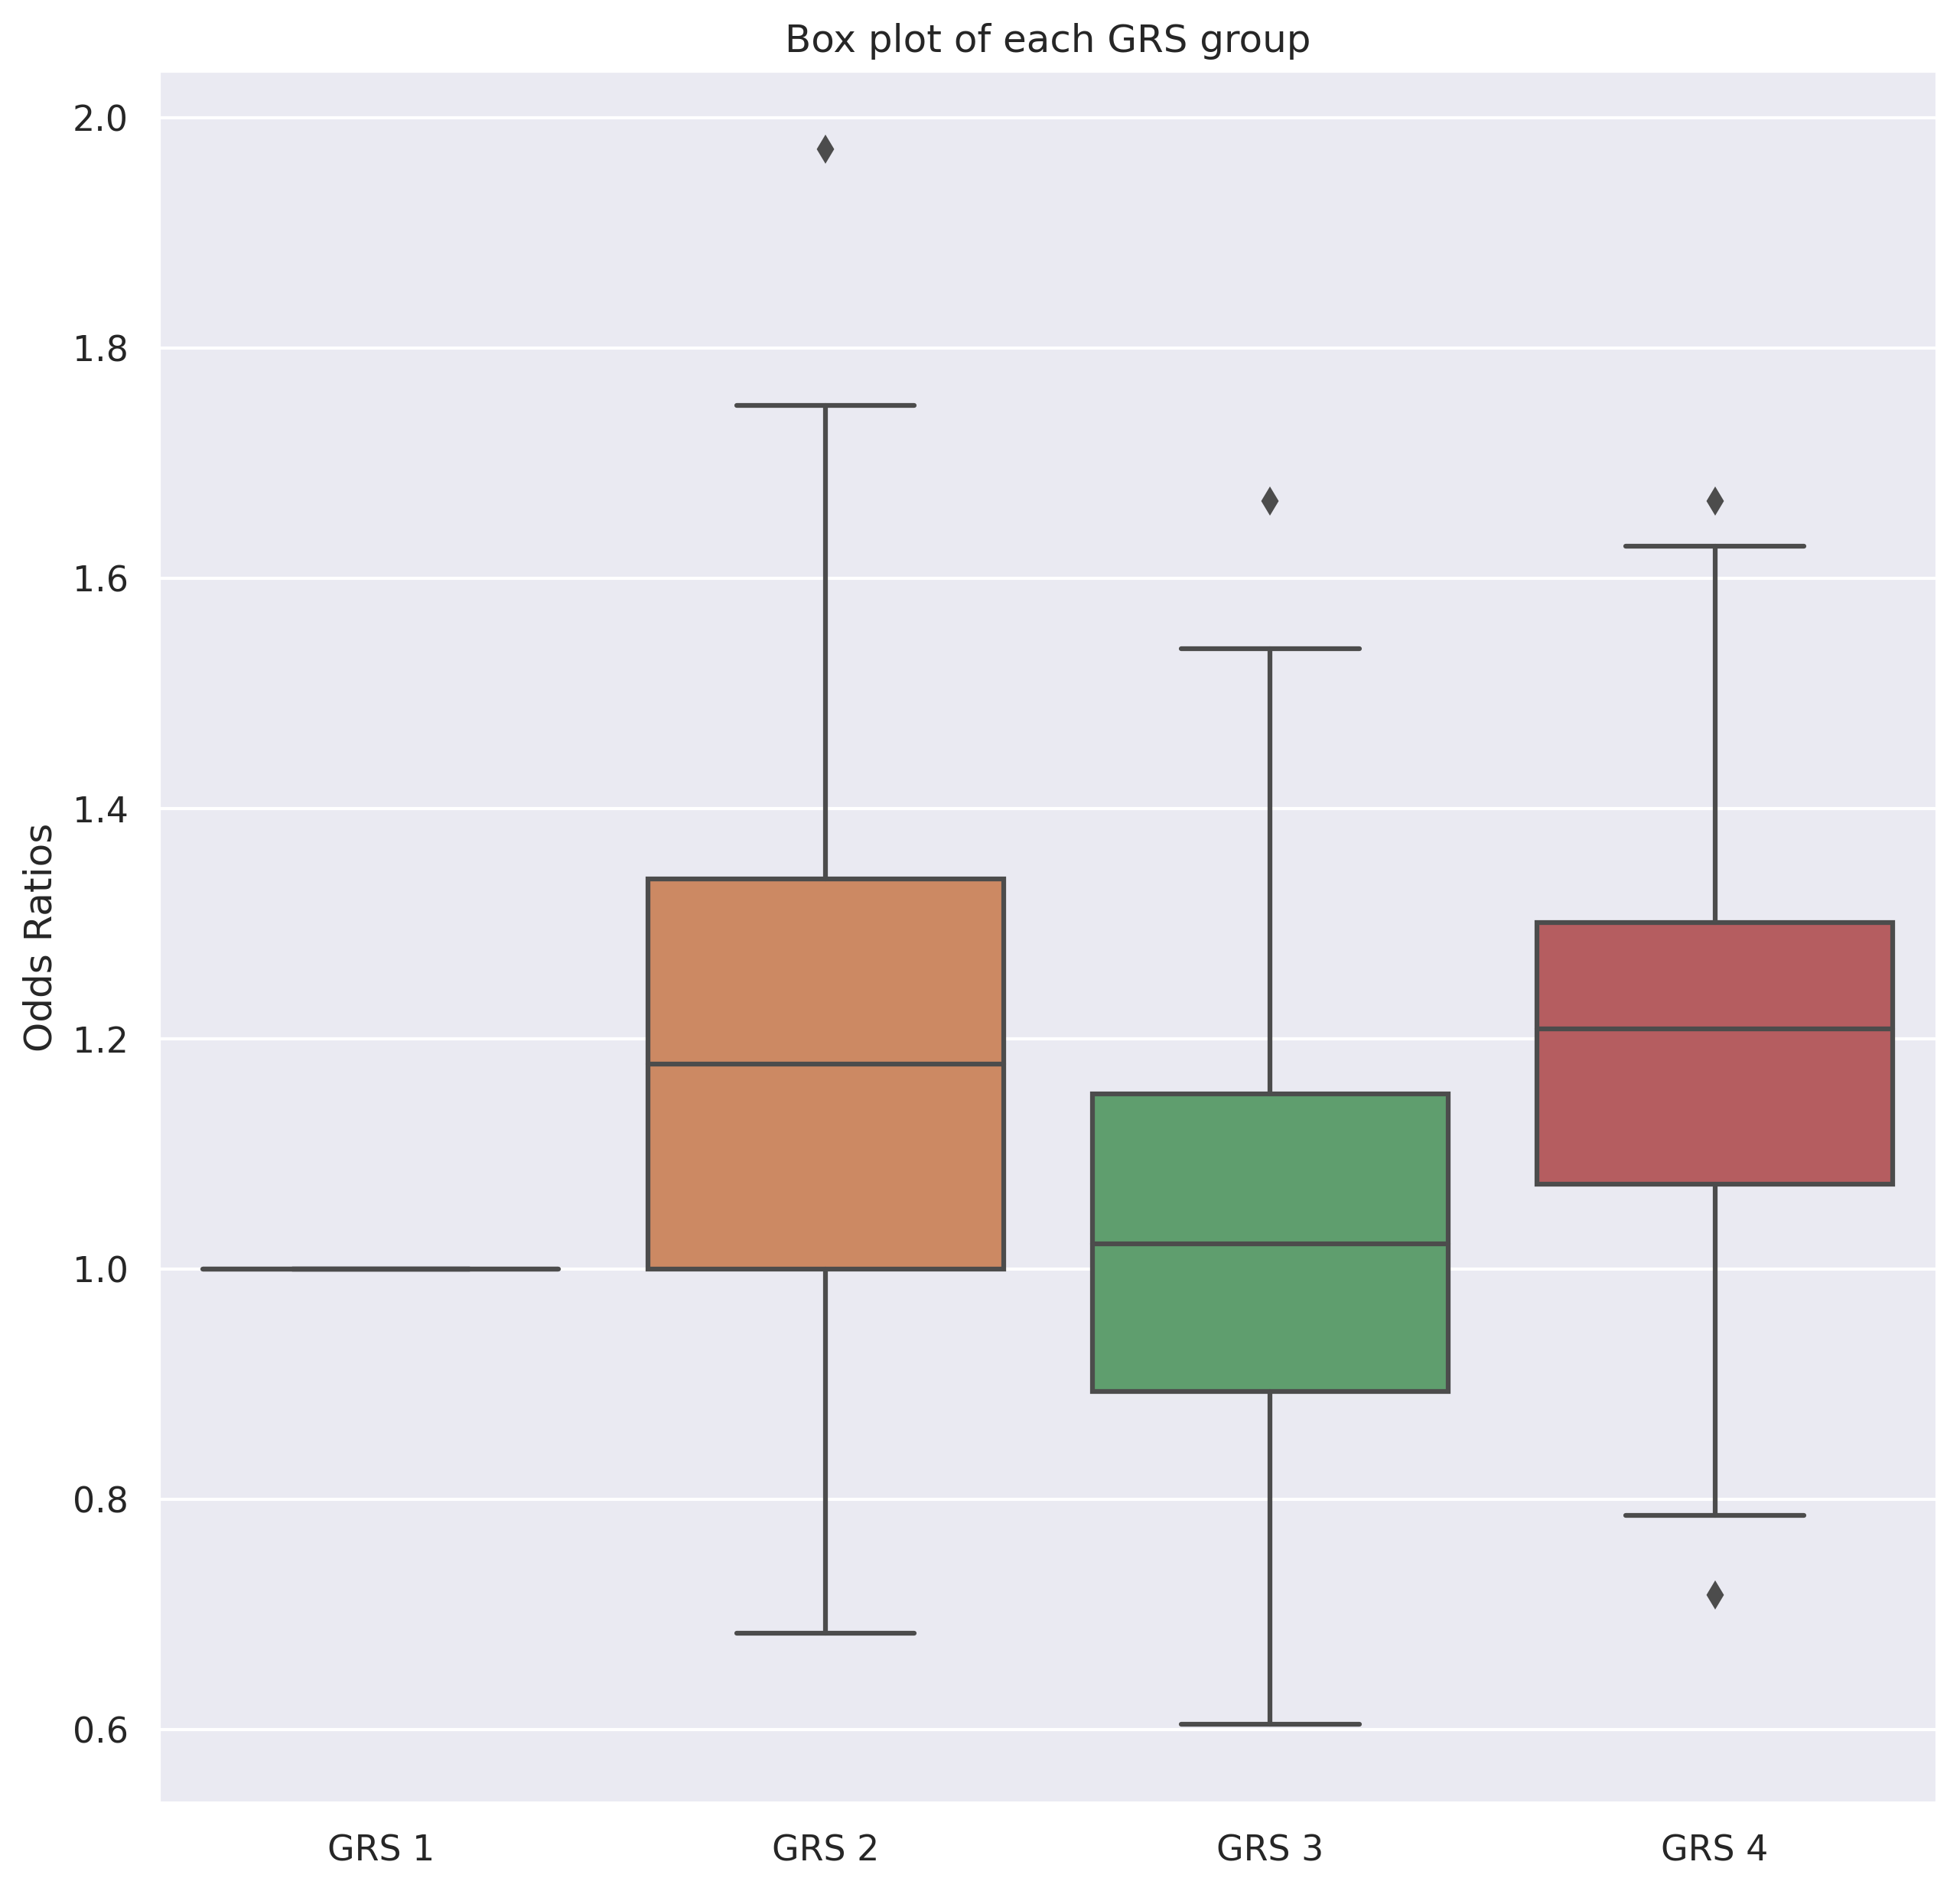

In [ ]:
# Box plot to visualise OR distributions

fig, ax = plt.subplots(1, figsize=(10, 10))
sns.boxplot(data =dist_df).set(ylabel = 'Odds Ratios', title = 'Box plot of each GRS group')

plt.show()
